In [ ]:
%pip install torch torchvision transformers
%pip install wandb

In [ ]:
import os
import json
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class ImageCaptionDataset(Dataset):
    def __init__(self, img_dir, seg_dir, caption_file, transform=None):
        self.img_dir = img_dir
        self.seg_dir = seg_dir
        self.transform = transform
        with open(caption_file, 'r') as f:
            self.captions = json.load(f)
        self.filenames = list(self.captions.keys())

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        seg_name = 'segmented_' + img_name  #Adjusting name for segmented images

        img_path = os.path.join(self.img_dir, img_name)
        seg_path = os.path.join(self.seg_dir, seg_name)

        image = Image.open(img_path).convert('RGB')
        segmentation = Image.open(seg_path).convert('L')

        if self.transform:
            image = self.transform(image)
            segmentation = self.transform(segmentation)

        caption = self.captions[img_name]
        return image, segmentation, caption


# Transformations
transform = transforms.Compose([
    transforms.CenterCrop((512, 512)),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

In [ ]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np

def apply_sobel_operator(segmentation):
    sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).view(1, 1, 3, 3)
    sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).view(1, 1, 3, 3)
    
    # Ensure the segmentation tensor is float and has a batch dimension
    if len(segmentation.shape) == 2:
        segmentation = segmentation.unsqueeze(0).unsqueeze(0)
    elif len(segmentation.shape) == 3:
        segmentation = segmentation.unsqueeze(1)

    edges_x = F.conv2d(segmentation, sobel_x, padding=1)
    edges_y = F.conv2d(segmentation, sobel_y, padding=1)

    edges = torch.sqrt(edges_x**2 + edges_y**2)

    threshold = edges.mean() * 1.5
    binary_mask = (edges > threshold).float()

    return binary_mask

def apply_canny_edge_detector(segmentation, low_threshold=100, high_threshold=200):
    """
    Applies the Canny edge detector to a PyTorch tensor representing an image and returns a binary mask of the edges.

    Args:
        image_tensor (torch.Tensor): A tensor representing the image. Expected shape (B, H, W) where B is the size of batch.
        low_threshold (int): Lower threshold for the hysteresis process in Canny.
        high_threshold (int): Higher threshold for the hysteresis process in Canny.

    Returns:
        torch.Tensor: A binary mask where edges are 1 and non-edges are 0, as a tensor.
    """
    segmentation = segmentation * 255
    batch_np = segmentation.numpy().astype(np.uint8)
    
    # Initialize an empty list to collect edge maps
    edge_maps = []
    
    # Process each image in the batch
    for image_np in batch_np:
        blurred_image = cv2.GaussianBlur(image_np, (3, 3), 0)
        edges = cv2.Canny(blurred_image, low_threshold, high_threshold)
        edge_maps.append(edges)
    
    # Convert list of arrays back to a tensor
    edge_tensor = torch.from_numpy(np.stack(edge_maps, axis=0).astype(np.uint8))
    return edge_tensor

class Params:
    def __init__(self):
        self.batch_size = 64
        self.learning_rate = 0.001
        self.epochs = 10

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer

class DiffusionModel(nn.Module):
    def __init__(self):
        super(DiffusionModel, self).__init__()
        self.text_encoder = BertModel.from_pretrained('bert-base-uncased')
        self.beta_network = nn.Sequential(
            nn.Linear(768, 100),
            nn.Sigmoid()
        )
        self.delta_network = nn.Sequential(
            nn.Linear(768, 1),
            nn.Sigmoid()
        )
        self.recovery_network = nn.Sequential(
            nn.Linear(768, 128), 
            nn.ReLU(),  
            nn.Linear(128, 64),  
            nn.ReLU(),  
            nn.Linear(64, 3),
            nn.Sigmoid()
        )

    def compute_delta(self, text_features, t):
        # Compute the delta value based on text features and timestep
        delta_scale = self.delta_network(text_features).squeeze()
        return delta_scale

    def forward_pass(self, x_t_minus_1, m, captions, t, beta_t):
        # Get text features from the text encoder
        inputs = tokenizer(captions, return_tensors="pt", padding=True, truncation=True)
        text_features = self.text_encoder(**inputs).pooler_output

        # Get beta for this timestep
        beta = beta_t[t]

        # Compute delta
        delta = self.compute_delta(text_features, t)
        delta = delta.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        weighted_noise = delta * torch.sqrt(beta * (1 - m))

        # Generate noise
        noise = torch.randn_like(x_t_minus_1) * weighted_noise

        # Compute the next timestep value
        x_t = torch.sqrt(1 - beta) * x_t_minus_1 + noise
        return x_t


    def reverse_pass(self, x_t, m, captions, t, beta_t):
        # Get text features from the text encoder
        inputs = tokenizer(captions, return_tensors="pt", padding=True, truncation=True)
        text_features = self.text_encoder(**inputs).pooler_output

        # Compute delta
        delta = self.compute_delta(text_features, t)
        delta = delta.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

        # Compute recovery parameters
        recovery_params = self.recovery_network(text_features)
        recovery_params = recovery_params.view(-1, 3, 1, 1)
        
        x_t_minus_1 = (recovery_params * (1-m)) + (x_t * m)
        return x_t_minus_1

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [ ]:
def diffusion_loss(x_t, x_t1_pred, m):
    return ((x_t1_pred - x_t) ** 2 * (1 - m)).mean()

In [ ]:
import wandb
from sklearn.model_selection import KFold
import torch
from torch.utils.data import DataLoader

# Setup
T = 1000  # Total number of diffusion steps
beta_start = 0.0001
beta_end = 0.02
beta_t = torch.linspace(beta_start, beta_end, steps=T)

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
num_epochs = 10

# Initialize W&B
# wandb.init(project='image_captioning_with_diffusion_models', entity='michaelpeng72', config={
#     "epochs": num_epochs,
#     "batch_size": 16,
#     "learning_rate": 1e-4,
#     "n_splits": n_splits,
#     "shuffle": True,
#     "random_state": 42
# })

# config = wandb.config
config = Params()

full_dataset = ImageCaptionDataset('datasets/images', 'datasets/segmented', 'datasets/map.json', transform=transform)

for fold, (train_idx, valid_idx) in enumerate(kf.split(full_dataset)):
    print(f"Starting Fold {fold+1}/{n_splits}")
    # wandb.init(project='image_captioning_with_diffusion_models', entity='michaelpeng72', group="Experiment-X", job_type=f"Fold-{fold+1}", reinit=True)

    # Data loaders
    train_subset = torch.utils.data.Subset(full_dataset, train_idx)
    valid_subset = torch.utils.data.Subset(full_dataset, valid_idx)
    train_loader = DataLoader(train_subset, batch_size=config.batch_size, shuffle=True)
    valid_loader = DataLoader(valid_subset, batch_size=config.batch_size, shuffle=False)

    # Initialize model and optimizer
    model = DiffusionModel()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

    # Training
    model.train()
    for epoch in range(config.epochs):
        train_loss = 0
        for images, segmentations, captions in train_loader:
            m = apply_sobel_operator(segmentations)
            # m = apply_canny_edge_detector(segmentations)
            t = torch.randint(0, T, (1,)).item()

            # Forward diffusion process
            noised_images = model.forward_pass(images, m, captions, t, beta_t)

            # Reverse diffusion process
            recovered_images = model.reverse_pass(noised_images, m, captions, t, beta_t)

            # Calculate loss
            # loss = torch.nn.functional.mse_loss(recovered_images, images)
            loss = diffusion_loss(images, recovered_images, m)
            train_loss += loss.item()

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= len(train_loader)
        # wandb.log({"Train Loss": train_loss})

        # Validation
        model.eval()
        valid_loss = 0
        with torch.no_grad():
            for images, segmentations, captions in valid_loader:
                m = apply_sobel_operator(segmentations)
                # m = apply_canny_edge_detector(segmentations)
                t = torch.randint(0, T, (1,)).item()
                
                # Same forward and reverse pass for validation
                noised_images = model.forward_pass(images, m, captions, t, beta_t)
                recovered_images = model.reverse_pass(noised_images, m, captions, t, beta_t)

                # Calculate validation loss
                loss = torch.nn.functional.mse_loss(recovered_images, images)
                valid_loss += loss.item()

        valid_loss /= len(valid_loader)
        # wandb.log({"Validation Loss": valid_loss})
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")
        
    # wandb.finish()


In [ ]:
#save the model to ../models
torch.save(model.state_dict(), 'models/diffusion_model.pth')

In [ ]:
#load model from ../models
model = DiffusionModel()
model.load_state_dict(torch.load('models/diffusion_model.pth'))

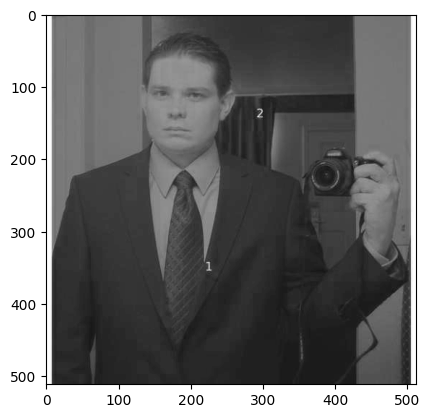

tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 0.9961,  ..., 0.9961, 1.0000, 1.0000],
         [1.0000, 1.0000, 0.9961,  ..., 0.9961, 1.0000, 1.0000],
         [1.0000, 1.0000, 0.9961,  ..., 0.9961, 1.0000, 1.0000],
         ...,
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 1.0000],
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 1.0000],
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.

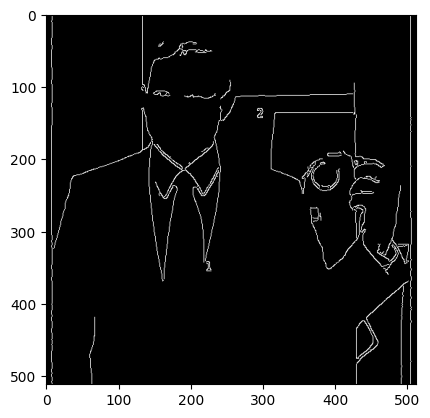

In [117]:
import matplotlib.pyplot as plt

example_segmented =  Image.open('datasets/segmented/segmented_COCO_val2014_000000000459.jpg').convert('RGB')
example_segmented = transform(example_segmented)

plt.imshow(example_segmented[0], cmap='gray')
plt.show()
print(example_segmented)
# m = apply_sobel_operator(example_segmented)
m = apply_canny_edge_detector(example_segmented, 10, 110)

#plot m
plt.imshow(m[0].numpy(), cmap='gray')
plt.show()